In [3]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

In [10]:
def load_data():
    # 加载数据MNIST, 训练集和测试集(train=True/False), 转换为张量(附带归一化 /255), 下载数据
    train_data = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
    test_data = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)
    print('train_data size:', train_data.data.size())
    print('test_data size:', test_data.data.size())
    
    # 数据加载器 DataLoader, 用于将数据分批次加载, shuffle=True表示打乱数据
    train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=False)
    return train_loader, test_loader

In [11]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 256)
        self.fc2 = torch.nn.Linear(256, 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [12]:
def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = []
    for images, labels in test_loader:
        # 数据加载到设备
        images, labels = images.to(device), labels.to(device)
        # 前向传播
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # 统计预测信息
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss.append(criterion(outputs, labels).item())
    
    return 100 * correct / total, test_loss

In [13]:
def train(model, train_loader, test_loader, optimizer, criterion, device):
    model.train()
    train_loss_all = []
    test_loss_all = []
    test_acc_all = []
    # 记录训练时间
    start_time = time.time()
    for i, (images, labels) in enumerate(train_loader):
        # 优化器梯度清零
        optimizer.zero_grad()
        # 数据加载到设备
        images, labels = images.to(device), labels.to(device)
        # 前向传播
        outputs = model(images)
        # 计算损失, 反向传播, 更新参数
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_all.append(loss.item())
        
        # 打印训练信息
        if (i+1) % 100 == 0:
            # 计算测试集准确率
            test_acc, test_loss = test(model, test_loader, criterion, device)
            test_loss_all.append(np.mean(test_loss))
            test_acc_all.append(test_acc)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.2f}%'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item(), np.mean(test_loss_all), test_acc))
    
    print("time used: {:.4f}".format(time.time()-start_time))    
    return train_loss_all, test_loss_all, test_acc_all   

In [14]:
# 开始训练, 使用GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: ", device)

# 加载数据
train_loader, test_loader = load_data()
# 初始化模型, 损失函数, 优化器
model = MLP().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3

device:  cuda
train_data size: torch.Size([60000, 28, 28])
test_data size: torch.Size([10000, 28, 28])


In [15]:
# 训练模型
train_loss_all = []
test_loss_all = []
test_acc_all = []
for epoch in range(num_epochs):
    train_loss, test_loss, test_acc = train(model, train_loader, test_loader, optimizer, criterion, device)
    train_loss_all.extend(train_loss)
    test_loss_all.extend(test_loss)
    test_acc_all.extend(test_acc)

Epoch [1/3], Step [100/469], Loss: 1.6381, Test Loss: 1.6075, Test Acc: 88.78%
Epoch [1/3], Step [200/469], Loss: 1.5741, Test Loss: 1.5873, Test Acc: 91.17%
Epoch [1/3], Step [300/469], Loss: 1.5408, Test Loss: 1.5758, Test Acc: 92.02%
Epoch [1/3], Step [400/469], Loss: 1.5534, Test Loss: 1.5685, Test Acc: 92.29%
time used: 7.0695
Epoch [2/3], Step [100/469], Loss: 1.5223, Test Loss: 1.5363, Test Acc: 93.32%
Epoch [2/3], Step [200/469], Loss: 1.5255, Test Loss: 1.5343, Test Acc: 93.57%
Epoch [2/3], Step [300/469], Loss: 1.5184, Test Loss: 1.5322, Test Acc: 93.84%
Epoch [2/3], Step [400/469], Loss: 1.5506, Test Loss: 1.5304, Test Acc: 94.20%
time used: 7.0190
Epoch [3/3], Step [100/469], Loss: 1.5157, Test Loss: 1.5185, Test Acc: 94.76%
Epoch [3/3], Step [200/469], Loss: 1.5114, Test Loss: 1.5177, Test Acc: 94.86%
Epoch [3/3], Step [300/469], Loss: 1.5172, Test Loss: 1.5165, Test Acc: 95.16%
Epoch [3/3], Step [400/469], Loss: 1.4979, Test Loss: 1.5157, Test Acc: 95.06%
time used: 7.034

In [16]:
# 开始训练, 使用CPU
device = torch.device('cpu')
print("device: ", device)

# 加载数据
train_loader, test_loader = load_data()
# 初始化模型, 损失函数, 优化器
model = MLP().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3

# 训练模型
train_loss_all = []
test_loss_all = []
test_acc_all = []
for epoch in range(num_epochs):
    train_loss, test_loss, test_acc = train(model, train_loader, test_loader, optimizer, criterion, device)
    train_loss_all.extend(train_loss)
    test_loss_all.extend(test_loss)
    test_acc_all.extend(test_acc)

device:  cpu
train_data size: torch.Size([60000, 28, 28])
test_data size: torch.Size([10000, 28, 28])
Epoch [1/3], Step [100/469], Loss: 1.6032, Test Loss: 1.5977, Test Acc: 89.78%
Epoch [1/3], Step [200/469], Loss: 1.5591, Test Loss: 1.5803, Test Acc: 91.39%
Epoch [1/3], Step [300/469], Loss: 1.5661, Test Loss: 1.5700, Test Acc: 92.40%
Epoch [1/3], Step [400/469], Loss: 1.5215, Test Loss: 1.5630, Test Acc: 92.86%
time used: 8.3934
Epoch [2/3], Step [100/469], Loss: 1.5066, Test Loss: 1.5340, Test Acc: 93.42%
Epoch [2/3], Step [200/469], Loss: 1.5273, Test Loss: 1.5316, Test Acc: 93.83%
Epoch [2/3], Step [300/469], Loss: 1.5229, Test Loss: 1.5296, Test Acc: 94.10%
Epoch [2/3], Step [400/469], Loss: 1.5262, Test Loss: 1.5274, Test Acc: 94.49%
time used: 8.1518
Epoch [3/3], Step [100/469], Loss: 1.5457, Test Loss: 1.5182, Test Acc: 94.88%
Epoch [3/3], Step [200/469], Loss: 1.4863, Test Loss: 1.5158, Test Acc: 95.19%
Epoch [3/3], Step [300/469], Loss: 1.5228, Test Loss: 1.5147, Test Acc: 

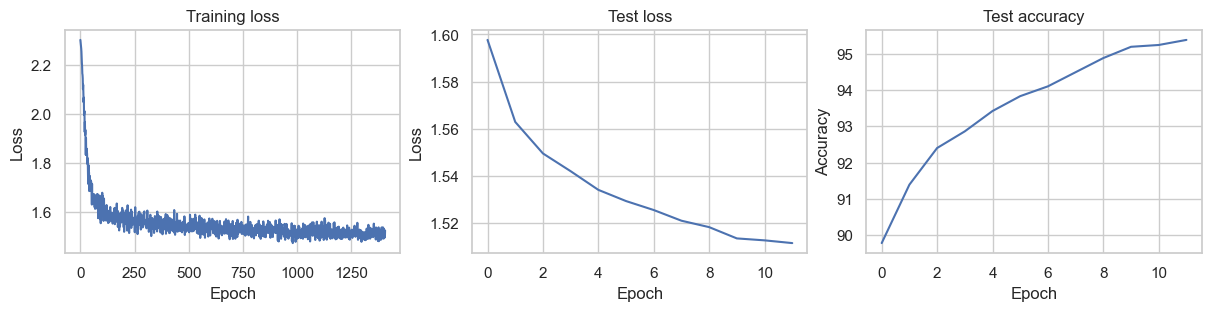

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制训练损失
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 3), constrained_layout=True)
plt.subplot(1, 3, 1)
sns.lineplot(x=range(len(train_loss_all)), y=train_loss_all)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')

plt.subplot(1, 3, 2)
sns.lineplot(x=range(len(test_loss_all)), y=test_loss_all)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test loss')

plt.subplot(1, 3, 3)
sns.lineplot(x=range(len(test_acc_all)), y=test_acc_all)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test accuracy')

plt.show()

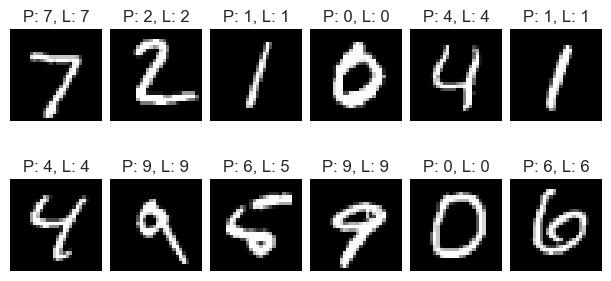

In [18]:
# 绘制实例
import matplotlib.pyplot as plt

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

plt.figure(figsize=(6, 3), constrained_layout=True)
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("P: %d, L: %d" % (predicted[i], labels[i]))
plt.show()